<a href="https://colab.research.google.com/github/wSedler/Cafe_Msk/blob/main/Cafe_Msc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Рынок заведений общественного питания Москвы

<b><font size="4">Описание проекта</font></b>  
Было решено открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Инвесторов интересует текущее положение дел на рынке — будет ли кафе популярным после того как все зеваки насмотрятся на роботов-официантов?  
Есть данные о заведениях общественного питания Москвы:
- id — идентификатор объекта
- object_name — название объекта общественного питания
- chain — сетевой ресторан или нет
- object_type — тип объекта общественного питания
- address — адрес
- number — количество посадочных мест  

Необходимо подготовить исследование рынка:
- Соотношение видов объектов общественного питания
- Соотношение сетевых и несетевых заведений
- Среднее количество посадочных мест

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import matplotlib.ticker as ticker
import math
import warnings
import re
sns.set(style='white')
sns.set_palette('bright') 

## Предобработка

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/rest_data.csv')

In [3]:
df.sample(10)

,id,object_name,chain,object_type,address,number
13274,198891,Hookah burger,нет,бар,"город Москва, Митинская улица, дом 16",10
12230,192371,МА ПИЦЦА,нет,предприятие быстрого обслуживания,"город Москва, улица Академика Анохина, дом 2, ...",12
3367,73308,Кофе-Хаус,да,кафе,"город Москва, Измайловская площадь, дом 1А",98
8700,148435,Pizzeria 360,нет,предприятие быстрого обслуживания,"город Москва, Кутузовский проспект, дом 57",30
1747,141381,КАФЕ «Кафе дра»,нет,кафе,"город Москва, Ломоносовский проспект, дом 25, ...",10
9673,168767,Золотая вобла,да,бар,"город Москва, Протопоповский переулок, дом 3",100
1085,147447,Barbecue Beer Bar,нет,бар,"город Москва, улица Сретенка, дом 26/1",45
15344,206756,Мята Lounge Октябрьская,да,кафе,"город Москва, Донская улица, дом 11, строение 2",48
9462,163491,Кофе,нет,кафетерий,"город Москва, улица Народного Ополчения, дом 3...",0
3719,23357,Столовая ГБОУ СОШ № 1358,нет,столовая,"город Москва, улица Барышиха, дом 42, корпус 2",240


In [4]:
len(df)

15366

In [5]:
df.duplicated().sum()

0

Полных дубликатов нет

In [6]:
df['object_name'] = df['object_name'].str.lower()

In [7]:
df[df.loc[:, df.columns != 'id'].duplicated()]

,id,object_name,chain,object_type,address,number
2381,28611,комбинат питания мгту им.н.э.баумана,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, стр...",100
3397,71896,буфет «коникс-школьник»,нет,буфет,"город Москва, улица Удальцова, дом 21",100
3481,20914,буфет мади,нет,буфет,"город Москва, Ленинградский проспект, дом 64",40
4431,23759,столовая гбоу города москвы № 384,нет,буфет,"город Москва, Беловежская улица, дом 67",100
4537,23391,столовая «комбинат питания космос»,нет,столовая,"город Москва, Новозаводская улица, дом 12/11",15
...,...,...,...,...,...,...
14578,222932,старый баку,нет,кафе,"город Москва, Кировоградская улица, владение 15А",120
14596,204947,буфет при кинотеатре,нет,буфет,"город Москва, Ореховый бульвар, дом 22А",0
14844,219518,sushi-make,нет,предприятие быстрого обслуживания,"город Москва, Ярцевская улица, дом 19",0
15173,218542,кофе с собой,да,предприятие быстрого обслуживания,"город Москва, Алтуфьевское шоссе, дом 70, корп...",0


Удалим дубликаты

In [8]:
df = df.loc[:, df.columns != 'id'].drop_duplicates()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15281 entries, 0 to 15365
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   object_name  15281 non-null  object
 1   chain        15281 non-null  object
 2   object_type  15281 non-null  object
 3   address      15281 non-null  object
 4   number       15281 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 716.3+ KB


Прорущенных значений нет

In [10]:
df.describe()

,number
count,15281.000000
mean,59.788234
std,74.843042
min,0.000000
25%,14.000000
50%,40.000000
75%,80.000000
max,1700.000000


In [11]:
df.query('number == 0')

,object_name,chain,object_type,address,number
137,пекарня & донер,нет,закусочная,"город Москва, Бутырская улица, дом 9, корпус 2",0
154,шаурма в пите,нет,предприятие быстрого обслуживания,"город Москва, Варшавское шоссе, дом 72, корпус 2",0
157,суши,нет,предприятие быстрого обслуживания,"город Москва, улица Маршала Василевского, дом ...",0
190,"шаурма, куры-гриль",нет,предприятие быстрого обслуживания,"город Москва, 1-я Владимирская улица, дом 21",0
195,"шаурма, куры-гриль",нет,предприятие быстрого обслуживания,"город Москва, 2-я Владимирская улица, дом 44/10",0
...,...,...,...,...,...
15334,милти,да,магазин (отдел кулинарии),"город Москва, Дубравная улица, дом 34/29",0
15335,милти,да,магазин (отдел кулинарии),"город Москва, Пятницкое шоссе, дом 3",0
15336,готовые блюда милти,да,предприятие быстрого обслуживания,"город Москва, Ореховый бульвар, дом 22А",0
15337,милти,да,предприятие быстрого обслуживания,"город Москва, 3-й Крутицкий переулок, дом 18",0


<b>Определение сетегого заведения:</b>  
"Обычно, называют число три или пять." Будем считать, что 3 и более заведений это уже сеть.
http://www.restcon.ru/index.php?section=article&article_id=653

In [12]:
pat = r"(?P<before>[^;]*)(?P<name>«[^;]*»)"

repl = lambda m: m.group('name')[1:-1]

df['object_name'] = df['object_name'].str.replace(pat, repl, regex=True).str.replace('«|»', '', regex=True)

In [13]:
df.head()

,object_name,chain,object_type,address,number
0,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,академия,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,вишневая метель,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [14]:
df['object_name'] = df['object_name'].str.replace('\w+ kfc|kfc \w+', 'kfc', regex=True)

In [15]:
pat = r"(?P<before>кафе) (?P<name>[^;]*)"

repl = lambda m: m.group('name')

df['object_name'] = df['object_name'].str.replace(pat, repl, regex=True)

In [16]:
(df.query('chain == "да"').groupby('object_name')['chain'].count().rename('cnt').reset_index()).query('cnt < 3')

,object_name,cnt
0,beverly hills diner,1
1,bierloga,1
2,black & white,1
4,boobo,1
5,bp,1
...,...,...
410,якитория и спорт бар,1
411,якитория и ян примус,1
412,ямми микс,1
413,ян примус,2


То что в Москве располагается один или два заведения еще не говорит, что это не сеть.

In [17]:
df[df['object_name'].str.find('школ') > -1]

,object_name,chain,object_type,address,number
12,школа 735,нет,столовая,"город Москва, Авиамоторная улица, дом 51",140
15,школа 1011,нет,столовая,"город Москва, улица Авиаторов, дом 18",320
23,гбоу школа № 1411 (970),нет,столовая,"город Москва, Алтуфьевское шоссе, дом 42Б",120
27,столовая при гуп объединенный комбинат школьно...,нет,столовая,"город Москва, улица Амундсена, дом 10",192
28,школа 1444,нет,столовая,"город Москва, Анадырский проезд, дом 55",240
...,...,...,...,...,...
13267,фуршет школа,нет,кафе,"город Москва, поселение Сосенское, посёлок Ком...",48
13273,столовая гбоу школа № 1387,нет,столовая,"город Москва, Машкинское шоссе, дом 7",192
13278,столовая гбоу школа № 1517,нет,столовая,"город Москва, Живописная улица, дом 11, корпус 3",80
13290,столовая гбоу школа № 1298,нет,столовая,"город Москва, Юровская улица, дом 99",192


In [18]:
(df[df['object_name'].str.find('школ') == -1].query('chain == "нет"').groupby('object_name')['object_name'].count().rename('cnt').reset_index()).query('cnt > 2')

,object_name,cnt
43,24 градуса,4
146,bb&burgers,5
257,burger heroes,4
277,cafetera,4
327,cinnabon,10
...,...,...
7992,шашлычок,3
7996,шварц кайзер,3
8020,шикари,6
8034,шоколадница,3


Эти заведения точно попадают в определение сети, изменим столбец chain

In [19]:
df.loc[df['object_name'].isin((df[df['object_name'].str.find('школ') == -1].query('chain == "нет"').groupby('object_name')['object_name'].count().rename('cnt').reset_index()).query('cnt > 2')['object_name'].values), 'chain'] = 'да'

In [20]:
df.duplicated().sum()

0

Если у заведения стоят отметки "сетевое" и "несетевое", то везде заменил на сетевое

Где все столбцы, кроме id и number, совпадают, удалил дубликаты, а за число посадочных мест взял среднее между дубликатами


In [21]:
df.loc[df.query('chain == "нет"')[df.query('chain == "нет"')['object_name'].isin(df.query('chain == "да"')['object_name'].unique())]['object_name'].index, 'chain'] = 'да'

In [22]:
df = pd.concat([df.loc[df.loc[:, df.columns != 'number'].drop_duplicates(keep=False).index], df[df.loc[:, df.columns != 'number'].duplicated(keep=False)].groupby(['object_name', 'chain', 'object_type', 'address']).mean().round().astype('int').reset_index()], sort=False).reset_index().drop('index', axis=1)

## Анализ

### Соотношение видов объектов общественного питания по количеству

In [23]:
#Функция для добавления подписей
def autolabel(rects, labels=None, height_factor=1.01):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if labels is not None:
            try:
                label = labels[i]
            except (TypeError, KeyError):
                label = ' '
        else:
            label = float(height)
        ax.text(rect.get_x() + rect.get_width()/2., height_factor*height,
                f'{label:.2f}',
                ha='center', va='bottom')

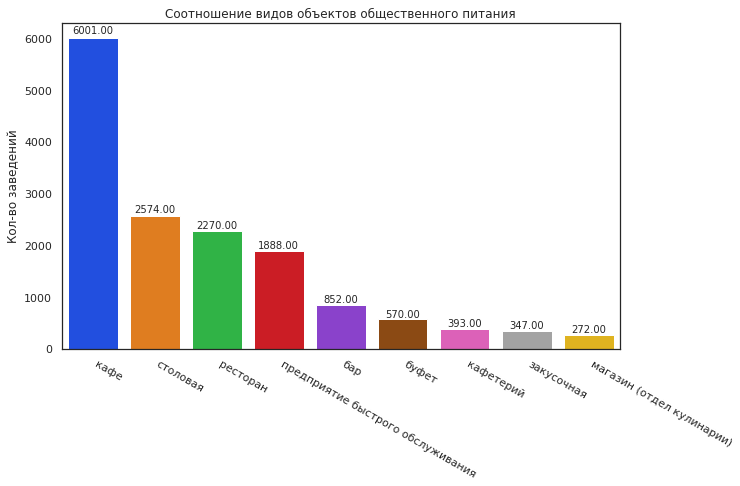

In [24]:
plt.figure(figsize=(10, 6))

sns.barplot(x=df['object_type'].value_counts().index, y=df['object_type'].value_counts())
plt.xticks(rotation=-30, ha='left')

plt.title('Соотношение видов объектов общественного питания')
plt.ylabel('Кол-во заведений')

ax = plt.gca()
autolabel(ax.patches, height_factor=1.01)

In [25]:
df['object_type'].value_counts()

кафе                                 6001
столовая                             2574
ресторан                             2270
предприятие быстрого обслуживания    1888
бар                                   852
буфет                                 570
кафетерий                             393
закусочная                            347
магазин (отдел кулинарии)             272
Name: object_type, dtype: int64

Кафе - наиболее распространенный вид общественного питания. Количество кафе больше количества столовых (второй по распространению вид) и ресторанов (третий по распространению вид) вместе взятых.  
Такое количество кафе говорит о том, что они пользуются спросом, но в то же время и конкуренция среди них высокая.

### Cоотношение сетевых и несетевых заведений по количеству

In [26]:
df['chain'].value_counts().reset_index()

,index,chain
0,нет,9268
1,да,5899


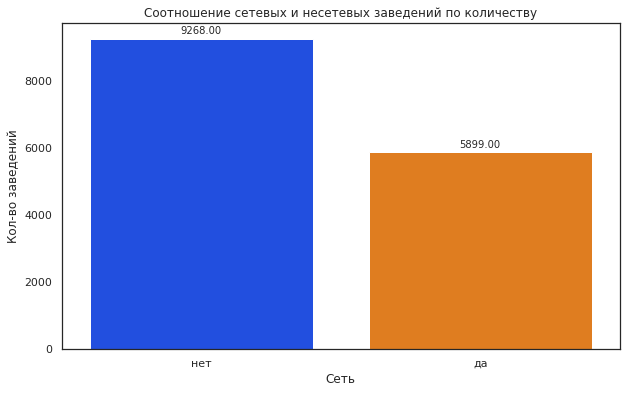

In [27]:
plt.figure(figsize=(10, 6))

sns.barplot(x=df['chain'].value_counts().index, y=df['chain'].value_counts())

plt.title('Cоотношение сетевых и несетевых заведений по количеству')
plt.ylabel('Кол-во заведений')
plt.xlabel('Сеть')

ax = plt.gca()
autolabel(ax.patches, height_factor=1.01)

Сетевых заведений намного меньше несетевых

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


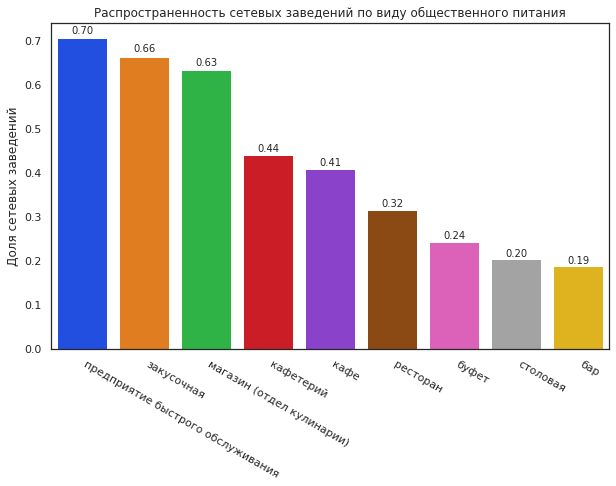

In [28]:
plt.figure(figsize=(10, 6))

g = sns.barplot((df.query('chain == "да"').groupby('object_type')['chain'].count() / df.groupby('object_type')['chain'].count()).sort_values(ascending=False).index, (df.query('chain == "да"').groupby('object_type')['chain'].count() / df.groupby('object_type')['chain'].count()).sort_values(ascending=False))

plt.xticks(rotation=-30, ha='left')

plt.title('Распространенность сетевых заведений по виду общественного питания')
plt.ylabel('Доля сетевых заведений')
plt.xlabel('')

ax = plt.gca()
autolabel(ax.patches, height_factor=1.01)

In [29]:
(df.query('chain == "да"').groupby('object_type')['chain'].count() / df.groupby('object_type')['chain'].count()).sort_values(ascending=False).reset_index()

,object_type,chain
0,предприятие быстрого обслуживания,0.704979
1,закусочная,0.662824
2,магазин (отдел кулинарии),0.632353
3,кафетерий,0.440204
4,кафе,0.408765
5,ресторан,0.316300
6,буфет,0.243860
7,столовая,0.203186
8,бар,0.187793


Сетевых кафе 40%  
Значит возможна конкуренция со стороны сетей, но не такая серьезная как среди фастфуда и закусочных

### Описание сетей

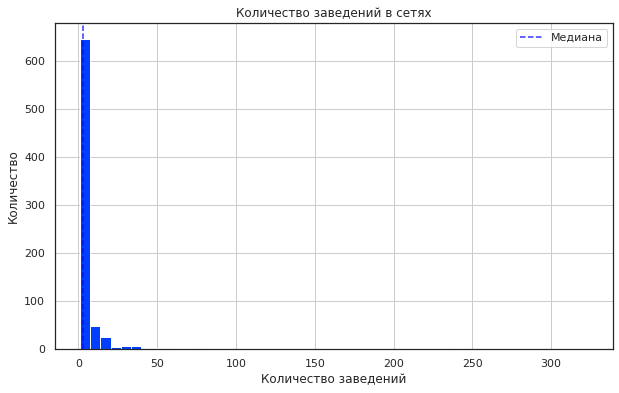

Text(0.5, 0, 'Количество заведений')

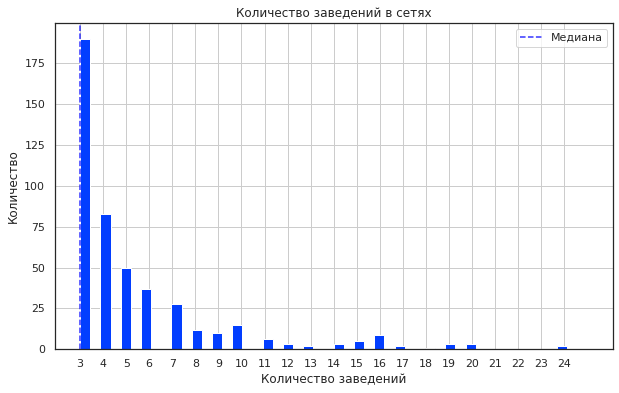

In [30]:
plt.figure(figsize=(10, 6))

df.query('chain == "да"').groupby('object_name')['object_name'].count().hist(bins=50)
plt.axvline(df.query('chain == "да"').groupby('object_name')['object_name'].count().median(), color = 'blue', alpha = 0.8, linestyle = 'dashed', label='Медиана')

plt.legend()
plt.title('Количество заведений в сетях')
plt.ylabel('Количество')
plt.xlabel('Количество заведений')
plt.show()


plt.figure(figsize=(10, 6))

df.query('chain == "да"').groupby('object_name')['object_name'].count().hist(bins=50, range=(3,25))
plt.axvline(df.query('chain == "да"').groupby('object_name')['object_name'].count().median(), color = 'blue', alpha = 0.8, linestyle = 'dashed', label='Медиана')

plt.xticks(range(3,25,1))
plt.legend()
plt.title('Количество заведений в сетях')
plt.ylabel('Количество')
plt.xlabel('Количество заведений')

Большинство сетей - небольшие. Половина имеет всего 3 заведения, но есть сети, где больше 300 заведений.  
Крупные сети на слуху и у них много ресурсов, поэтому будут сильными конкурентами, если будут недалеко

### Количество посадочных мест в сетевых и несетевых заведениях

In [31]:
def two_histograms(x, y, x_name, num_bins = 10, x_range = None):
  """Функция для создания двух гистограмм на одном графике со средними значениями выборок"""
  
  x.hist(bins = num_bins, alpha = 0.7, weights = [1/len(x)] * len(x), color = 'red', range=x_range)
  y.hist(bins = num_bins, alpha = 0.7, weights = [1/len(y)] * len(y), range=x_range)
  plt.axvline(x.mean(), color = 'red', alpha = 0.8, linestyle = 'dashed')
  plt.axvline(y.mean(), color = 'blue', alpha = 0.8, linestyle = 'dashed')
  plt.legend([x.name, y.name])
  title = f'Distribution of {x_name}'
  plt.title(title)
  x_name = x_name
  plt.xlabel(x_name)
  plt.ylabel("Relative frequency")

In [32]:
x = np.log(df.query('chain == "да"').groupby('object_name')['number'].mean() + 1)
y = np.log(df.query('chain == "нет"').groupby('object_name')['number'].mean() + 1)
x.name, y.name = 'Сетевой', 'Не сетевой'

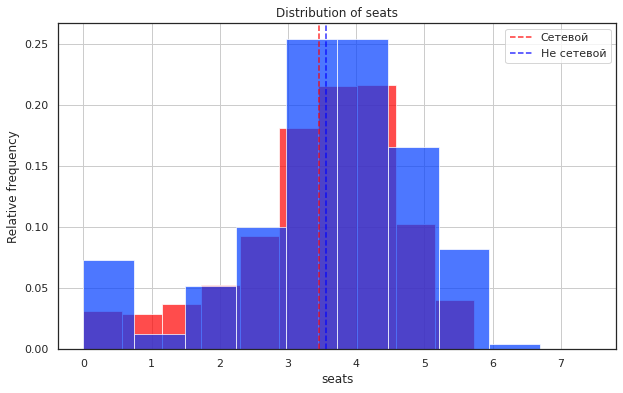

In [33]:
plt.figure(figsize=(10, 6))

two_histograms(x, y, 'seats', 10)

Предположим, что гистограммы условно нормальны. Тогда проверим с помощью критерия Флигнера-Килина, равны ли дисперсии.

**H0:** Дисперсии равны  
**H1:** Дисперсии не равны

In [34]:
res = stats.fligner(x, y)
print('p-value:', res[1])
print('alpha: 0.05')

p-value: 0.0210689002537184
alpha: 0.05


p-value меньше чем alpha, поэтому отвергаем гипотезу о равенстве дисперсий. Проведем t-test, предполагая не равенство дисперсий

**H0:** Распределения равны, разница в средних не значительна  
**H1:** Распределения не равны, разница в средних существенна

In [35]:
res = stats.ttest_ind(x, y, equal_var=False)
print('p-value:', res[1])
print('alpha: 0.05')

p-value: 0.018730618592032656
alpha: 0.05


p-value меньше чем alpha, отвергаем гипотезу о равенсве посадочных мест - разница в средних существенна

In [36]:
x = df.query('chain == "да"').groupby('object_name')['number'].mean()
y = df.query('chain == "нет"').groupby('object_name')['number'].mean()
x.name, y.name = 'Сетевой', 'Не сетевой'

Text(0, -40, '67.03')

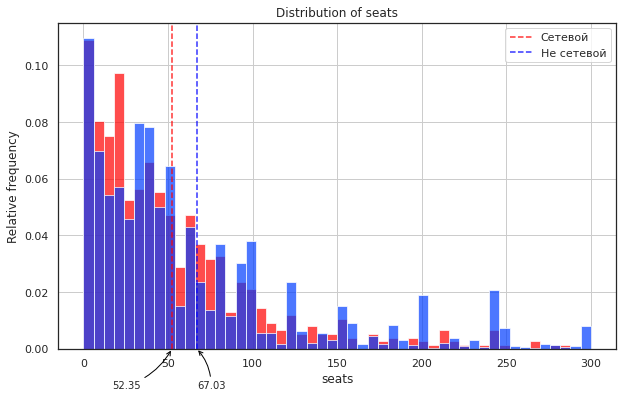

In [37]:
plt.figure(figsize=(10, 6))

two_histograms(x, y, 'seats', 50, (0,300))
plt.annotate(f"{x.mean():.2f}", xy=(x.mean(), 0), xycoords='data', xytext=(-60, -40), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2", color='black'))
plt.annotate(f"{y.mean():.2f}", xy=(y.mean(), 0), xycoords='data', xytext=(0, -40), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2", color='black'))

Если же распределения не нормальны, то по критерию Манна-Уитни:

**H0:** Распределения одинаковы, медианы равны. P{X > Y} = P{X < Y}  
**H1:** Распределения не одинаковы, медианы не равны. P{X > Y} ≠ P{X < Y}

In [38]:
res = stats.mannwhitneyu(x, y, alternative = 'two-sided')
print('p-value:', res[1])
print('alpha: 0.05')

p-value: 0.0004156014378687171
alpha: 0.05


p-value меньше чем alpha, отвергаем гипотезу о равенсве посадочных мест - разница существенна

В несетевых заведений количество посадочных мест больше  
Посмотрим за счет чего получается разниза

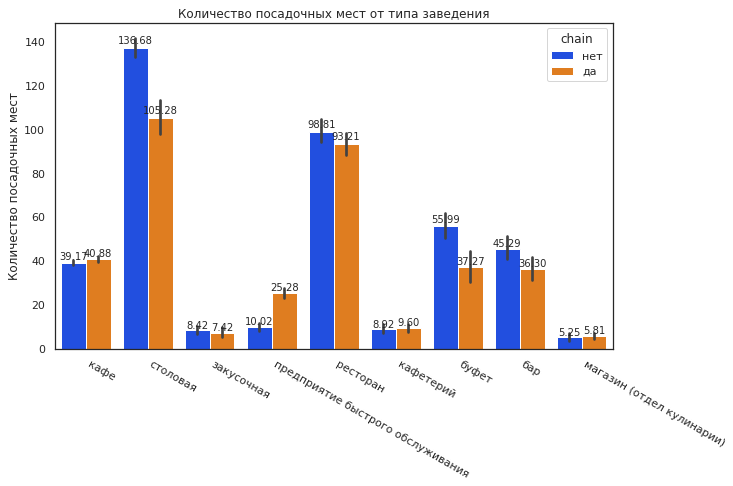

In [39]:
plt.figure(figsize=(10, 6))

sns.barplot(x='object_type', y='number', data=df, hue='chain')

plt.xticks(rotation=-30, ha='left')
plt.title('Количество посадочных мест от типа заведения')
plt.xlabel('')
plt.ylabel('Количество посадочных мест')

ax = plt.gca()
autolabel(ax.patches, height_factor=1.01)

Видно, что в несетевых столовых, буфетах и барах больше посадочных мест больше чем в сетевых, а вот в ПБО ситуация обратная

Больше всего посадочных мест в столовых(100-140), затем идут рестораны(около 95)  
В кафе, барах и буфетах среднее количество мест (40-60)  
В остальных немного посадочных мест, а иногда и не бывает  

In [40]:
x = df.query('chain == "да" and object_type == "кафе"').groupby('object_name')['number'].mean()
y = df.query('chain == "нет" and object_type == "кафе"').groupby('object_name')['number'].mean()
x.name, y.name = 'Сетевой', 'Не сетевой'

Text(0, -40, '41.32')

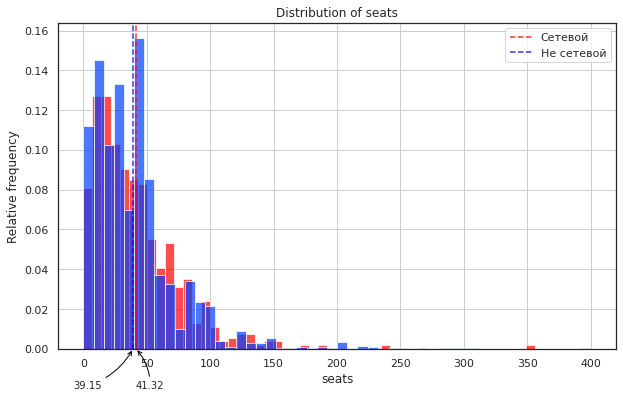

In [41]:
plt.figure(figsize=(10, 6))

two_histograms(x, y, 'seats', 50)
plt.annotate(f"{y.mean():.2f}", xy=(y.mean(), 0), xycoords='data', xytext=(-60, -40), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2", color='black'))
plt.annotate(f"{x.mean():.2f}", xy=(x.mean(), 0), xycoords='data', xytext=(0, -40), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2", color='black'))

Распределения не нормальны, тогда по критерию Манна-Уитни:

**H0:** Распределения одинаковы, медианы равны. P{X > Y} = P{X < Y}  
**H1:** Распределения не одинаковы, медианы не равны. P{X > Y} ≠ P{X < Y}

In [42]:
res = stats.mannwhitneyu(x, y, alternative = 'two-sided')
print('p-value:', res[1])
print('alpha: 0.05')

p-value: 0.08624738248599215
alpha: 0.05


p-value больше чем alpha, не отвергаем гипотезу о равенсве посадочных мест - разница в не существенна

Вывод: среди кафе не статистических различий в количестве посадочных мест

### Статистика заведений от улицы 

In [43]:
def street(row):
    
    for i in list(reversed(row.split(','))):
        if re.search(r'улица|переулок|шоссе|проспект|площадь|проезд|село|Проезд|аллея|бульвар|набережная|тупик|линия|квартал|поселение|микрорайон|километр|посёлок|территория Ленинские Горы|просек|город', i) != None:
            return i

In [44]:
df['street'] = df['address'].apply(street)

In [45]:
df['street'].value_counts().head(10)

 проспект Мира             194
 Профсоюзная улица         180
 Ленинградский проспект    170
 Пресненская набережная    164
 Варшавское шоссе          159
 Ленинский проспект        147
 город Зеленоград          128
 проспект Вернадского      126
 Кутузовский проспект      114
 Каширское шоссе           110
Name: street, dtype: int64

Районы Москвы, в которых находятся улицы:
1. <b>проспект Мира:</b> Мещанский, Марьина Роща, Алексеевский, Останкинский, Свиблово, Ростокино
2. <b>Профсоюзная улица:</b> Академический, Коньково, Обручевский, Тёплый Стан, Черёмушки, Ясенево.
3. <b>Ленинградский проспект:</b> Беговой, Аэропорт, Сокол, Хорошёвский
4. <b>Пресненская набережная:</b> Пресненский
5. <b>Варшавское шоссе:</b> Донской, Нагатино-Садовники, Нагорный, Чертаново Северное, Чертаново Центральное, Чертаново Южное, Южное Бутово, Щербинка
6. <b>Ленинский проспект:</b> Якиманка, Донской, Гагаринский, Ломоносовский, Обручевский, Тёплый Стан, Проспект Вернадского, Тропарёво-Никулино
7. <b>город Зеленоград:</b> Зеленоградский административный округ
8. <b>проспект Вернадского:</b> Гагаринский, Ломоносовский, Раменки, Проспект Вернадского, Тропарёво-Никулино
9. <b>Кутузовский проспект:</b> Дорогомилово, Фили-Давыдково
10. <b>Каширское шоссе:</b> Москворечье-Сабурово, Орехово-Борисово Северное, Орехово-Борисово Южное, Нагатино-Садовники

Это улицы, идущие с юга и запада Московской области в центр Москвы.

In [46]:
(df['street'].value_counts(ascending=True) == 1).sum()

626

In [47]:
df['street'].value_counts(ascending=True).head(10)

 Елоховский проезд                   1
 Рубцов переулок                     1
 переулок Васнецова                  1
 2-й Верхний Михайловский проезд     1
Алтуфьевское шоссе                   1
 3-я Песчаная улица                  1
1-я Тверская-Ямская улица            1
 улица Полины Осипенко               1
 Большой Полуярославский переулок    1
Профсоюзная улица                    1
Name: street, dtype: int64

Чем дальше от центра, тем больше улиц имеют всего по одному объекту общественного питания

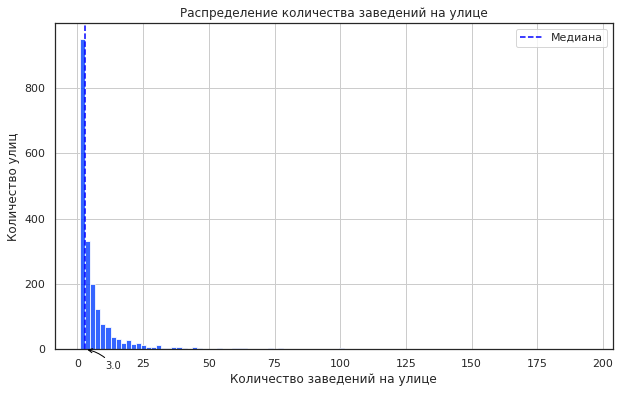

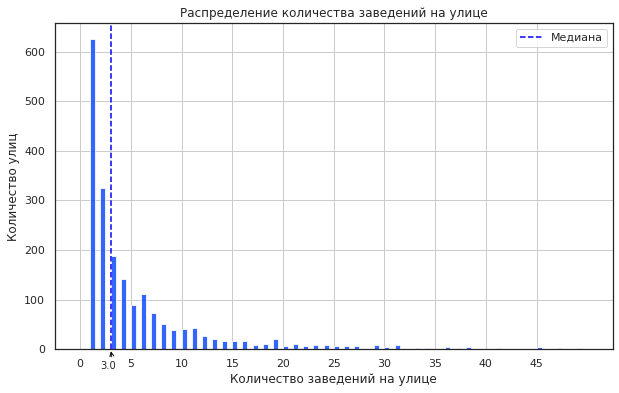

In [48]:
plt.figure(figsize=(10, 6))

df['street'].value_counts().hist(bins=100, alpha = 0.8)
plt.axvline(df['street'].value_counts().median(), color = 'blue', linestyle = 'dashed', label='Медиана')
plt.annotate(f"{df['street'].value_counts().median():.2}", xy=(df['street'].value_counts().median(), 0), xycoords='data', xytext=(20, -20), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2", color='black'))

plt.legend()
plt.title('Распределение количества заведений на улице')
plt.ylabel('Количество улиц')
plt.xlabel('Количество заведений на улице')
plt.show()


plt.figure(figsize=(10, 6))

df['street'].value_counts().hist(bins=100, alpha = 0.8, range=(0,50))
plt.axvline(df['street'].value_counts().median(), color = 'blue', linestyle = 'dashed', label='Медиана')
plt.annotate(f"{df['street'].value_counts().median():.2}", xy=(df['street'].value_counts().median(), 0), xycoords='data', xytext=(-10, -20), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2", color='black'))

plt.legend()
plt.title('Распределение количества заведений на улице')
plt.ylabel('Количество улиц')
plt.xlabel('Количество заведений на улице')
plt.xticks(range(0,50,5))

plt.show()

Очень много улиц имеют всего по одному заведению, а половина до 3.  
Значит можно выбрать место, где конкуренция будет невысокой

In [49]:
df.groupby('street')['number'].mean()

street
 1-й Автозаводский проезд     38.000000
 1-й Амбулаторный проезд      70.000000
 1-й Балтийский переулок      60.000000
 1-й Басманный переулок       50.000000
 1-й Ботанический проезд      40.000000
                                ...    
улица Ленинская Слобода       91.250000
улица Льва Толстого           66.666667
улица Миклухо-Маклая         110.000000
улица Обручева                40.000000
улица Сергея Макеева          15.000000
Name: number, Length: 2026, dtype: float64

Text(0.5, 1, 'Зависимость количества посадочных мест от количества заведений на улице')

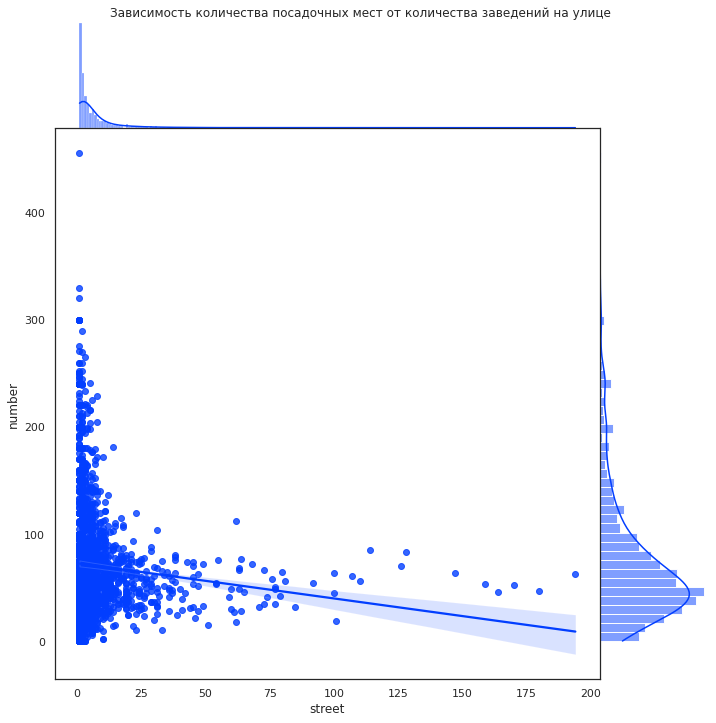

In [50]:
sns.jointplot(x=df.groupby('street')['street'].count(), y=df.groupby('street')['number'].mean(), kind='reg', height=10, space=0)

plt.suptitle('Зависимость количества посадочных мест от количества заведений на улице', y = 1)

In [51]:
x = df[df['street'].isin(df['street'].value_counts().reset_index().query('street > 100')['index'])]['number']
y = df[df['street'].isin(df['street'].value_counts().reset_index().query('street <= 100')['index'])]['number']
x.name, y.name = 'Улицы, где много заведений', 'Улицы, где не много заведений'

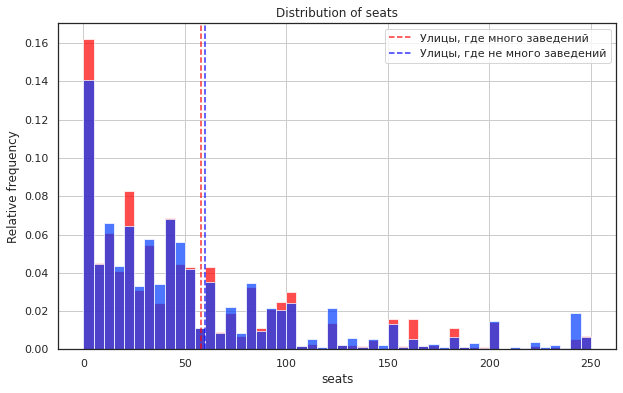

In [52]:
plt.figure(figsize=(10, 6))

two_histograms(x, y, 'seats', 50, (0, 250))

Распределения не нормальны, тогда по критерию Манна-Уитни:

**H0:** Распределения одинаковы, медианы равны. P{X > Y} = P{X < Y}  
**H1:** Распределения не одинаковы, медианы не равны. P{X > Y} ≠ P{X < Y}

In [53]:
res = stats.mannwhitneyu(x, y, alternative = 'two-sided')
print('p-value:', res[1])
print('alpha: 0.05')

p-value: 0.02982697674450727
alpha: 0.05


p-value меньше чем alpha, отвергаем гипотезу о равенсве посадочных мест - разница существенна

На улицах, где много заведений, количество посадочных мест меньше, чем на улицах, где заведений не так много  
Вывод: чем больше заведений общественного питания на улице, тем меньше посадочных мест нужно

In [54]:
pip install -U plotly

In [55]:
pip install -U geopy

In [56]:
def house(row):
    
    for i in list(reversed(row.split(','))):
        if re.search(r'дом', i) != None:
            return re.search(r'\d+/\d+|\d+', i)[0]
    
    for i in list(reversed(row.split(','))):
        if re.search(r'владение', i) != None:
            return re.search(r'\d', i)[0]

    for i in list(reversed(row.split(','))):
        if re.search(r'корпус', i) != None:
            return re.search(r'\d', i)[0]

    for i in list(reversed(row.split(','))):
        if re.search(r'строение', i) != None:
            return re.search(r'\d', i)[0]

In [57]:
df['house'] = df['address'].apply(house)

In [58]:
import requests
import time
from geopy.geocoders import Nominatim

def coordinates(row):
   
    street = row['street']
    house = row['house']

    geolocator = Nominatim(user_agent="http")
    location = geolocator.geocode(f"{house}, {street}, Москва")
    if location != None:
        lat = location.latitude
        lon = location.longitude

        return pd.Series([lat, lon])
    else:
        return None

In [59]:
df

,object_name,chain,object_type,address,number,street,house
0,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,9
1,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,2/1
2,академия,да,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица,6
3,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица,1
4,вишневая метель,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица,9
...,...,...,...,...,...,...,...
15162,шоколадница,да,кафе,"город Москва, Ходынский бульвар, дом 4",15,Ходынский бульвар,4
15163,шоколадница,да,кафе,"город Москва, площадь Джавахарлала Неру, дом 1",35,площадь Джавахарлала Неру,1
15164,шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",15,улица Земляной Вал,33
15165,щербакова людмила анатольевна,нет,кафе,"город Москва, улица Сущёвский Вал, дом 5, стро...",22,улица Сущёвский Вал,5


In [60]:
# Код выполнил локально

"""
my_dict = {}

def reg(i):
    try:
        print('Итерация:', i)
        x ='a' + str(i)
        my_dict[x] = df.loc[200*i:200*(i+1)-1].apply(coordinates, axis=1)
    except:
        time.sleep(1.1)
        reg(i)

for i in range(0,77):
    reg(i)
"""
    

"\nmy_dict = {}\n\ndef reg(i):\n    try:\n        print('Итерация:', i)\n        x ='a' + str(i)\n        my_dict[x] = df.loc[200*i:200*(i+1)-1].apply(coordinates, axis=1)\n    except:\n        time.sleep(1.1)\n        reg(i)\n\nfor i in range(0,77):\n    reg(i)\n"

In [61]:
# Код выполнил локально

"""
concat_list = []
for i in range(0,77):
    concat_list.append(my_dict['a'+str(i)])
"""

"\nconcat_list = []\nfor i in range(0,77):\n    concat_list.append(my_dict['a'+str(i)])\n"

In [62]:
# Код выполнил локально

"""
pd.concat(concat_list)
"""

'\npd.concat(concat_list)\n'

In [63]:
# Код выполнил локально

"""
df[['lat', 'lon']] = pd.concat(concat_list)
"""

"\ndf[['lat', 'lon']] = pd.concat(concat_list)\n"

In [64]:
from io import BytesIO
import requests
spreadsheet_id = '167iT5kdMD9xyraCeFlvdQUR9EQAIwpn1TmYSPNIKjRo'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))
df = df.drop('Unnamed: 0', axis=1)
df

,object_name,chain,object_type,address,number,street,house,lat,lon
0,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,9,"55,87899365","37,71459318"
1,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,2/1,"55,73808985","37,67319557"
2,академия,да,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица,6,"55,7353041","37,6695415"
3,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица,1,"55,89385905","37,57329918"
4,вишневая метель,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица,9,"55,90376055","37,56977051"
...,...,...,...,...,...,...,...,...,...
15162,шоколадница,да,кафе,"город Москва, Ходынский бульвар, дом 4",15,Ходынский бульвар,4,"55,7899666","37,53102443"
15163,шоколадница,да,кафе,"город Москва, площадь Джавахарлала Неру, дом 1",35,площадь Джавахарлала Неру,1,"55,6930838","37,5340151"
15164,шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",15,улица Земляной Вал,33,"55,7572385","37,6593527"
15165,щербакова людмила анатольевна,нет,кафе,"город Москва, улица Сущёвский Вал, дом 5, стро...",22,улица Сущёвский Вал,5,"55,794556","37,5949972"


In [65]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode(f"{df['house'][0]}, {df['street'][0]}, Москва")

In [66]:
print(location.address)
print((location.latitude, location.longitude))

9, улица Егора Абакумова, Лось, Ярославский район, Москва, Центральный федеральный округ, 129347, Россия
(55.87899365, 37.7145931801882)


In [67]:
df.query('lat.isna() and not lon.isna()', engine="python")

,object_name,chain,object_type,address,number,street,house,lat,lon


In [68]:
df.query('lon.isna() and not lat.isna()', engine="python")

,object_name,chain,object_type,address,number,street,house,lat,lon
1406,we cidreria,нет,ресторан,"город Москва, Благовещенский переулок, дом 5",60,Благовещенский переулок,5,0 55.76800\n1 37.59865\ndtype: float64,NaN
1407,кофейня,да,кафе,"город Москва, улица Палиха, дом 9",9,улица Палиха,9,0 55.785192\n1 37.600343\ndtype: float64,NaN
1408,якитория,да,кафе,"город Москва, Осенний бульвар, дом 18, корпус 1",90,Осенний бульвар,18,0 55.762107\n1 37.408361\ndtype: float64,NaN
1409,микс,да,кафе,"город Москва, Рублёвское шоссе, дом 16, корпус 1",48,Рублёвское шоссе,16,0 55.740335\n1 37.433751\ndtype: float64,NaN
1410,квартира 44,да,кафе,"город Москва, Большая Никитская улица, дом 22/2",78,Большая Никитская улица,22/2,0 55.757279\n1 37.603249\ndtype: float64,NaN
...,...,...,...,...,...,...,...,...,...
2595,ника,нет,столовая,"город Москва, Малая Юшуньская улица, дом 4",60,Малая Юшуньская улица,4,0 55.654337\n1 37.595068\ndtype: float64,NaN
2596,паб бразен,нет,кафе,"город Москва, улица Кржижановского, дом 20/30,...",80,улица Кржижановского,20/30,0 55.678645\n1 37.571582\ndtype: float64,NaN
2597,ск чертаново,нет,кафе,"город Москва, микрорайон Северное Чертаново, к...",36,микрорайон Северное Чертаново,8,0 55.632408\n1 37.590013\ndtype: float64,NaN
2598,витражи,нет,бар,"город Москва, улица Каховка, дом 11, корпус 1",40,улица Каховка,11,0 55.649219\n1 37.587678\ndtype: float64,NaN


In [69]:
def replace(row):
    
    lat = row['lat']
    lon = row['lon']
    
    if str(lat) != 'None' and str(lat) != 'nan' and str(lon) == 'nan':
        row['lon'] = re.findall(r'\d+.\d+', lat)[1]
        row['lat'] = re.findall(r'\d+.\d+', lat)[0]
    return row

In [70]:
df = df.apply(replace, axis=1)

In [71]:
df['lat'] = df['lat'].str.replace(',', '.').astype('float')
df['lon'] = df['lon'].str.replace(',', '.').astype('float')

In [72]:
import plotly.express as px

fig = px.scatter_mapbox(df, lat="lat", lon="lon", color='object_type', zoom=10, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Видно, что чем ближе к центру Москвы, тем больше плотность точек общественного питания

## Вывод

1. Кафе - наиболее распространенный вид общественного питания. Количество кафе больше количества столовых (второй по распространению вид) и ресторанов (третий по распространению вид) вместе взятых. <b>Такое количество кафе говорит о том, что они пользуются спросом, но в то же время и конкуренция среди них высокая.</b>
2. Сетевых кафе 40%. Значит возможна конкуренция со стороны сетей, но не такая серьезная как среди фастфуда и закусочных
3. Большинство сетей - небольшие. Половина имеет всего 3 заведения, но есть сети, где больше 300 заведений. Крупные сети на слуху и у них много ресурсов, поэтому будут сильными конкурентами, если будут недалеко
4. Видно, что в несетевых столовых, буфетах и барах больше посадочных мест больше чем в сетевых, а вот в ПБО ситуация обратная
5. Среди сетевых и несетевых кафе не статистических различий в количестве посадочных мест 
6. На улицах, идущих с юга и запада Московской области в центр Москвы, больше всего заведений.
7. Чем дальше от центра, тем больше улиц имеют всего по одному объекту общественного питания
8. Очень много улиц имеют всего по одному заведению, а половина до 3. Значит можно выбрать место, где конкуренция будет невысокой
9. На улицах, где много заведений, количество посадочных мест меньше, чем на улицах, где заведений не так много. Чем больше заведений общественного питания на улице, тем меньше посадочных мест нужно
10. Видно, что чем ближе к центру Москвы, тем больше плотность точек общественного питания